In [1]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

from smt.sampling_methods import LHS
from scipy.io import savemat

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)
import matplotlib.pyplot as plt

device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

cuda:2


In [62]:
class Sequentialmodel1(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
    
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data) 
            
        self.beta = Parameter(0.25*torch.ones((layers[1],len(layers)-2)))
        self.beta.requiresGrad = True

    
    'forward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = 2.0*(x - l_b)/(u_b - l_b) - 1.0 #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(z)
            
        a = self.linears[-1](a) 
         
        return a  
    
    def forward1(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = 2.0*(x - l_b)/(u_b - l_b) - 1.0 #feature scaling
        
        #convert to float
        a = x.float()
        
        z = self.linears[0](a)
        a = self.activation(z)
         
        return a 
    
    
    def loss_PDE(self,x_coll,f_hat):
            g = x_coll.clone()             
            g.requires_grad = True
  
            u = self.forward(g) 

            u_x = autograd.grad(u,g,torch.ones([x.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
            
            du_dx = u_x[:,[0]]
            
            
            f = du_dx - torch.cos(x)
            
            return self.loss_function(f,f_hat)
        
    def loss(self,x_train,u_train):
        return self.loss_function(self.forward(x_train),u_train)

In [63]:
m = 5.0

x = torch.from_numpy(np.linspace(-1,1,100).reshape(-1,1)).float().to(device)
ub = np.array([1.0])
lb = np.array([-1.0])

x_train = x
u_train = torch.sin(m*x).float().to(device)

layers = np.array([1,5,1]) #9 hidden layers

torch.manual_seed(124)
PINN1 = Sequentialmodel1(layers)
PINN1.to(device)

optimizer = optim.LBFGS(PINN1.parameters(), lr=0.1)

def closure():
    optimizer.zero_grad()     # zeroes the gradient buffers of all parameters
    loss = PINN1.loss(x_train,u_train)
    loss.backward() #backprop
    
    return loss

for i in range(400):
        
    optimizer.step(closure)
    
    loss_np = PINN1.loss(x_train,u_train).cpu().detach().numpy()
    print(i,"Train Loss",loss_np)
    
    if(loss_np<=0.001):
        break

loss_np = PINN1.loss(x_train,u_train).cpu().detach().numpy()
print(i,"Train Loss",loss_np)

0 Train Loss 0.5111052
1 Train Loss 0.4989224
2 Train Loss 0.2849477
3 Train Loss 0.02183979
4 Train Loss 0.011314954
5 Train Loss 0.009525938
6 Train Loss 0.005336498
7 Train Loss 0.004797401
8 Train Loss 0.0042724186
9 Train Loss 0.0040830993
10 Train Loss 0.003291707
11 Train Loss 0.002732458
12 Train Loss 0.0021188704
13 Train Loss 0.0019958515
14 Train Loss 0.001975356
15 Train Loss 0.0018231246
16 Train Loss 0.001626533
17 Train Loss 0.001590242
18 Train Loss 0.0015195155
19 Train Loss 0.001299375
20 Train Loss 0.0011865821
21 Train Loss 0.0011113258
22 Train Loss 0.001076866
23 Train Loss 0.0010638052
24 Train Loss 0.0010608623
25 Train Loss 0.0010603477
26 Train Loss 0.0010545207
27 Train Loss 0.0009783806
27 Train Loss 0.0009783806


tensor(5.9456, device='cuda:2', grad_fn=<MaxBackward1>)


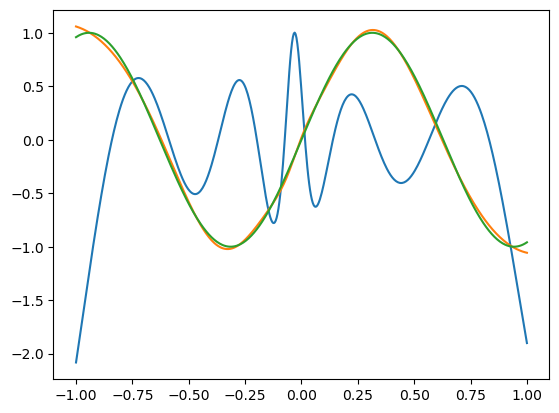

In [64]:
x_test = torch.from_numpy(np.linspace(-1,1,500).reshape(-1,1)).float().to(device)
g = x_test.clone()             
g.requires_grad = True

u = PINN1.forward(g) 

u_x = autograd.grad(u,g,torch.ones([x_test.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]

du_dx = u_x[:,[0]]

diff = du_dx.cpu().detach().numpy()-m*np.cos(m*x_test.cpu().detach().numpy())

# print(np.mean(np.abs(diff)))
# print(np.std(np.abs(diff)))
print(torch.max(du_dx))


plt.plot(x_test.cpu().detach().numpy(),diff)
plt.plot(x_test.cpu().detach().numpy(),u.cpu().detach().numpy())
plt.plot(x_test.cpu().detach().numpy(),np.sin(m*x_test.cpu().detach().numpy()))
# plt.ylim([-8,8])

In [58]:
b = PINN1.linears[1].bias.data.cpu().detach().numpy()
c = torch.max(u).cpu().detach().numpy()
mac = np.max(np.abs(PINN1.linears[0].weight.data.cpu().detach().numpy()))
miz = np.min(np.abs(PINN1.forward1(x_test).cpu().detach().numpy()))
print(torch.max(du_dx))
print((c-b)*mac/miz)

tensor(16.1118, device='cuda:2', grad_fn=<MaxBackward1>)
[-295488.53]


In [65]:
mac1 = np.max(np.abs(PINN1.linears[0].weight.data.cpu().detach().numpy()))
mac2 = np.max(np.abs(PINN1.linears[1].weight.data.cpu().detach().numpy()))
50*mac1*mac2

17887.99936963005

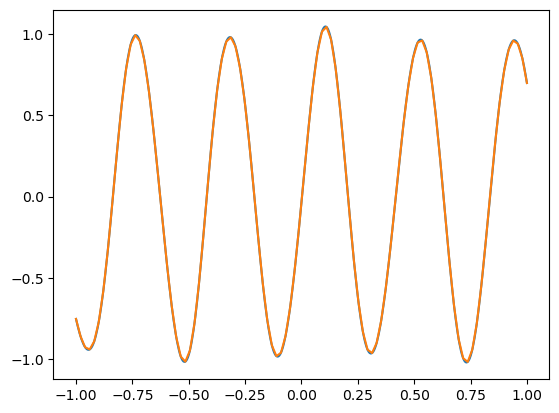

In [6]:
plt.plot(x_test.cpu().detach().numpy(),u.cpu().detach().numpy())
plt.plot(x.cpu().detach().numpy(),PINN1.forward(x).cpu().detach().numpy()) 

In [7]:
# plt.plot(x.cpu().detach().numpy(),PINN1.forward(x).cpu().detach()/ np.sin(8*x.cpu().detach().numpy()),'r')
# plt.plot(x.cpu().detach().numpy(),PINN2.forward(x).cpu().detach()/ np.sin(8*x.cpu().detach().numpy()),'b')

In [38]:
class Sequentialmodel2(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
    
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data) 
            
        self.beta = Parameter(0.25*torch.ones((layers[1],len(layers)-2)))
        self.beta.requiresGrad = True

    
    'forward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = 2.0*(x - l_b)/(u_b - l_b) - 1.0 #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(z)
            
        a = self.linears[-1](a) 
         
        return a  
    
    
    def forward1(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = 2.0*(x - l_b)/(u_b - l_b) - 1.0 #feature scaling
        
        #convert to float
        a = x.float()
        
        z = self.linears[0](a)
        a = self.activation(z)
         
        return a 
    
    
    def loss_PDE(self,x_coll,f_hat):
            g = x_coll.clone()             
            g.requires_grad = True
  
            u = self.forward(g) 

            u_x = autograd.grad(u,g,torch.ones([x.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
            
            du_dx = u_x[:,[0]]
            
            
            f = du_dx - torch.cos(x)
            
            return self.loss_function(f,f_hat)
        
    def loss(self,x_train,u_train):
        return self.loss_function(self.forward(x_train),u_train)

In [39]:
x = torch.from_numpy(np.linspace(-1,1,100).reshape(-1,1)).float().to(device)
ub = np.array([1.0])
lb = np.array([-1.0])

x_train = x
u_train = torch.sin(m*x).float().to(device)

layers = np.array([1,50,1]) #9 hidden layers

torch.manual_seed(124)
PINN2 = Sequentialmodel2(layers)
PINN2.to(device)

optimizer = optim.LBFGS(PINN2.parameters(), lr=0.1)

def closure():
    optimizer.zero_grad()     # zeroes the gradient buffers of all parameters
    loss = PINN2.loss(x_train,u_train)
    loss.backward() #backprop
    
    return loss

for i in range(200):
        
    optimizer.step(closure)
    
    loss_np = PINN2.loss(x_train,u_train).cpu().detach().numpy()
    print(i,"Train Loss",loss_np)
    
    if(loss_np<=0.001):
        break
loss_np = PINN2.loss(x_train,u_train).cpu().detach().numpy()
print(i,"Train Loss",loss_np)

0 Train Loss 0.5053594
1 Train Loss 76.94955
2 Train Loss 1.2689842
3 Train Loss 0.533549
4 Train Loss 0.4961026
5 Train Loss 0.49104598
6 Train Loss 0.48847556
7 Train Loss 0.48567733
8 Train Loss 0.48277494
9 Train Loss 0.48142767
10 Train Loss 0.48054668
11 Train Loss 0.47974917
12 Train Loss 0.4793671
13 Train Loss 0.47776732
14 Train Loss 0.44587058
15 Train Loss 0.4170782
16 Train Loss 0.38231298
17 Train Loss 0.33917674
18 Train Loss 0.30321324
19 Train Loss 0.27584723
20 Train Loss 0.25280312
21 Train Loss 0.24948727
22 Train Loss 0.24860378
23 Train Loss 0.24822482
24 Train Loss 0.24587382
25 Train Loss 0.24141972
26 Train Loss 0.23690002
27 Train Loss 0.21673776
28 Train Loss 0.1575101
29 Train Loss 0.08285612
30 Train Loss 0.033437695
31 Train Loss 0.024527755
32 Train Loss 0.013704728
33 Train Loss 0.009086992
34 Train Loss 0.007620282
35 Train Loss 0.006131028
36 Train Loss 0.0054851747
37 Train Loss 0.0044831783
38 Train Loss 0.0034988415
39 Train Loss 0.002660361
40 Trai

tensor(16.1140, device='cuda:2', grad_fn=<MaxBackward1>)


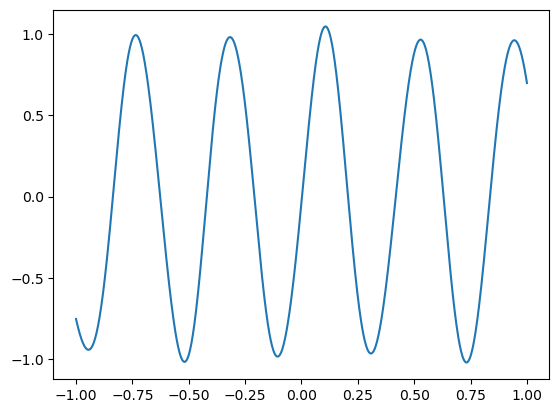

In [40]:
x_test = torch.from_numpy(np.linspace(-1,1,1000).reshape(-1,1)).float().to(device)
g = x_test.clone()             
g.requires_grad = True

u = PINN2.forward(g) 

u_x = autograd.grad(u,g,torch.ones([x_test.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]

du_dx = u_x[:,[0]]

diff = du_dx.cpu().detach().numpy()-m*np.cos(m*x_test.cpu().detach().numpy())

# print(np.mean(np.abs(diff)))
# print(np.std(np.abs(diff)))
print(torch.max(du_dx))

# plt.plot(x_test.cpu().detach().numpy(),diff)
plt.plot(x_test.cpu().detach().numpy(),u.cpu().detach().numpy())
# plt.plot(x_test.cpu().detach().numpy(),np.sin(m*x_test.cpu().detach().numpy()))

In [44]:
b = PINN2.linears[1].bias.data.cpu().detach().numpy()
c = 1.1
mac = np.max(np.abs(PINN2.linears[0].weight.data.cpu().detach().numpy()))
miz = np.min(PINN2.forward1(x_test).cpu().detach().numpy())
print(torch.max(du_dx))
print((c-b)*mac*miz)

tensor(16.1140, device='cuda:2', grad_fn=<MaxBackward1>)
[24.999763]


In [35]:
mac

8.025599